In [24]:
#  Healthcare Data Analysis and Prediction
# This script performs data preprocessing, exploratory data analysis (EDA), and predictive modeling on a healthcare dataset.
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, mean_absolute_error, mean_squared_error
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Load dataset
df = pd.read_csv('healthcare_ds.csv') 

# Keep relevant columns only
df = df[['Age', 'Gender', 'Blood Type', 'Medical Condition', 'Admission Type',
         'Test Results', 'Medication', 'Billing Amount', 'Date of Admission', 'Discharge Date']]

# Convert date columns
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'], errors='coerce')
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'], errors='coerce')
df['Length of Stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days
df.dropna(inplace=True)

# Emergency flag
df['Is_Emergency'] = df['Admission Type'].apply(lambda x: 1 if x == 'Emergency' else 0)

# Dividing diseases into  Critical and Non-Critical 
def categorize_condition(condition):
    condition = str(condition).lower()
    critical_keywords = ['cancer', 'tumor', 'stroke', 'cardiac', 'arrest', 'heart', 'failure', 'trauma', 'critical', 'coma']
    for keyword in critical_keywords:
        if keyword in condition:
            return 1
    return 0

df['Medical Condition'] = df['Medical Condition'].apply(categorize_condition)

# Label Encoding
le = LabelEncoder()
for col in ['Gender', 'Blood Type', 'Admission Type', 'Test Results', 'Medication']:
    df[col] = le.fit_transform(df[col].astype(str))

df['Billing_per_day'] = df['Billing Amount'] / (df['Length of Stay'] + 1)

# Scale numerical features
scaler = StandardScaler()
df[['Age', 'Billing Amount', 'Length of Stay', 'Billing_per_day']] = scaler.fit_transform(
    df[['Age', 'Billing Amount', 'Length of Stay', 'Billing_per_day']]
)



In [25]:
print("\n--- Disease Prediction (Random Forest) ---")
# Prepare features and target
X = df.drop(['Medical Condition', 'Date of Admission', 'Discharge Date'], axis=1)
y = df['Medical Condition']

# Stratified split to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Class distribution before SMOTE:")
print(y_train.value_counts())

#Apply SMOTE to balance the dataset
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_res).value_counts())



--- Disease Prediction (Random Forest) ---
Class distribution before SMOTE:
Medical Condition
0    37018
1     7382
Name: count, dtype: int64
Class distribution after SMOTE:
Medical Condition
0    37018
1    37018
Name: count, dtype: int64



--- Training Random Forest Classifier ---

--- Binary Classification: Critical vs Non-Critical ---
Accuracy Using RandomForestClassifier: 0.7874774774774774
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      9255
           1       0.33      0.26      0.29      1845

    accuracy                           0.79     11100
   macro avg       0.59      0.58      0.58     11100
weighted avg       0.77      0.79      0.78     11100

AUC-ROC Score: 0.6230656248215642

--- Training KNeighborsClassifier ---
Accuracy Using KNeighborsClassifier: 0.6151351351351352
              precision    recall  f1-score   support

           0       0.86      0.65      0.74      9255
           1       0.20      0.45      0.28      1845

    accuracy                           0.62     11100
   macro avg       0.53      0.55      0.51     11100
weighted avg       0.75      0.62      0.66     11100

AUC-ROC Score: 0.5639817633184436


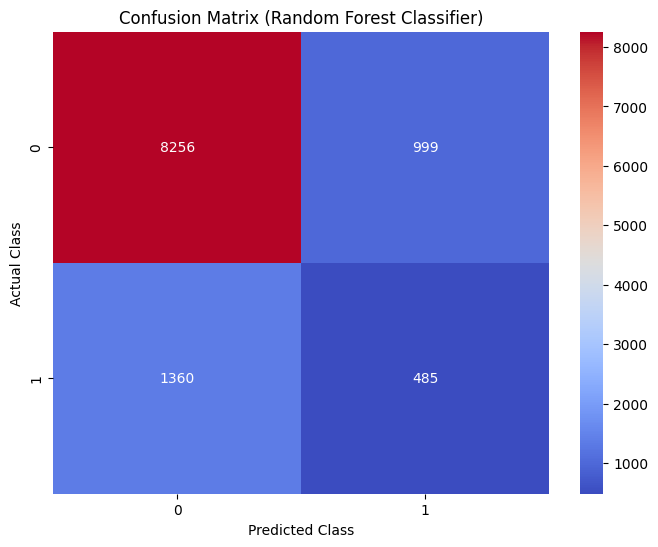

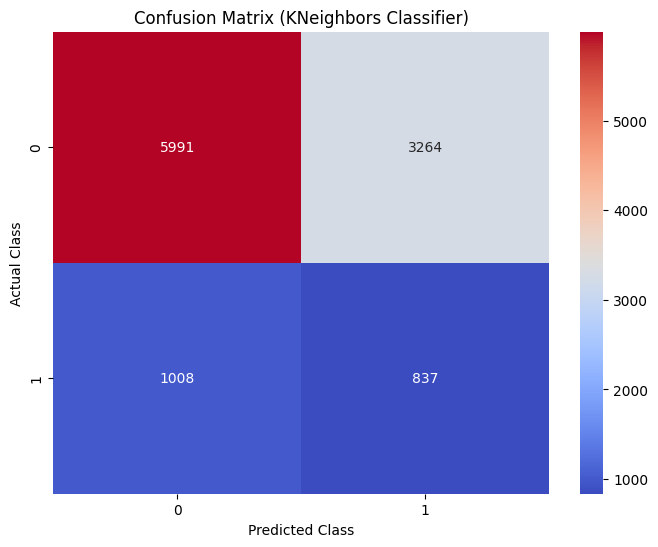

In [26]:
#Train Random Forest Classifier
print("\n--- Training Random Forest Classifier ---")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_res, y_res)
y_pred = rf.predict(X_test)

print("Accuracy Using RandomForestClassifier:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# AUC-ROC Score
y_proba = rf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print("AUC-ROC Score:", roc_auc)

#Train KNeighbors Classifier 
print("\n--- Training KNeighborsClassifier ---")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_res, y_res)
knn_pred = knn.predict(X_test)
# knn_acc = accuracy_score(y_test, knn_pred)

print("Accuracy Using KNeighborsClassifier:", accuracy_score(y_test, knn_pred))
print(classification_report(y_test, knn_pred))

# AUC-ROC Score
knn_proba = knn.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, knn_proba)
print("AUC-ROC Score:", roc_auc)


cm_rfc = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_rfc, annot=True, fmt="d", cmap="coolwarm")
plt.title('Confusion Matrix (Random Forest Classifier)')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

cm_knc = confusion_matrix(y_test, knn_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm_knc, annot=True, fmt="d", cmap="coolwarm")
plt.title('Confusion Matrix (KNeighbors Classifier)')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()



--- SHAP Explainability ---


<Figure size 1000x600 with 0 Axes>

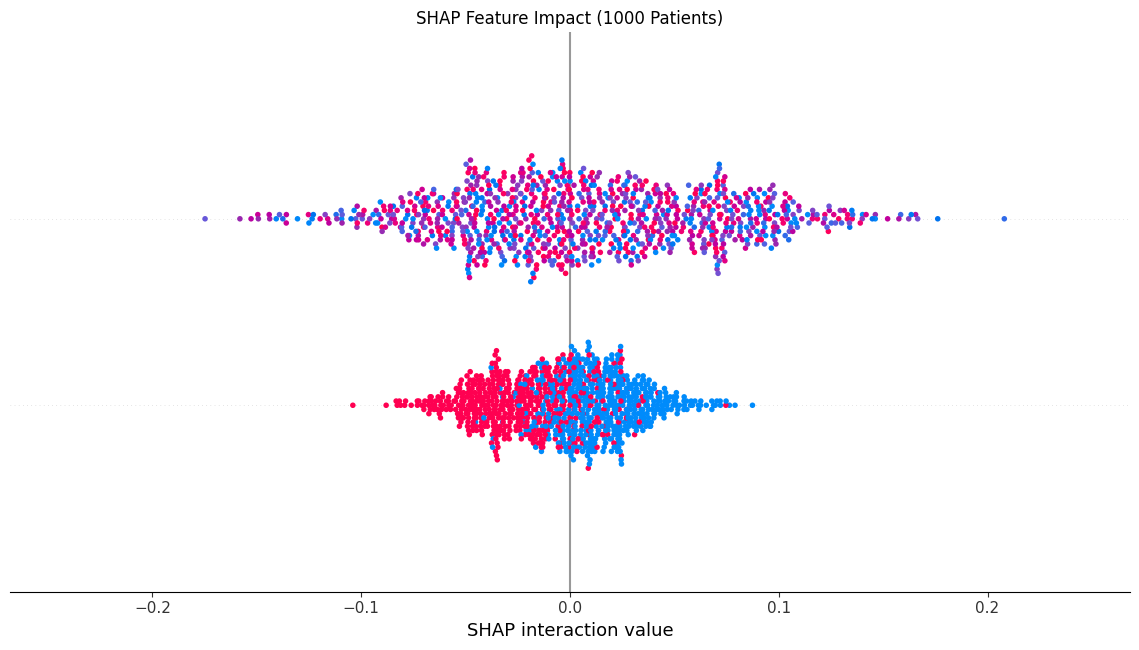

In [34]:
# Model Explainability (SHAP)
print("\n--- SHAP Explainability ---")
# Sample 1000 patients to reduce memory usage
sample_idx = np.random.choice(X_test.index, 1000, replace=False)
X_sample = X_test.loc[sample_idx]

# Generate SHAP values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)

# Plot with explicit rendering
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values, 
    X_sample, 
    plot_type="bar", 
    feature_names=X_test.columns.tolist(), 
    show=False
)
plt.title("SHAP Feature Impact (1000 Patients)")
plt.tight_layout()
plt.show()

55500

--- Patient Risk Clustering (K-Means) ---
Silhouette Score: 0.242
Davies-Bouldin Index: 1.326

--- Patient Risk Clustering (AgglomerativeClustering) ---
Silhouette Score: 0.201
Davies-Bouldin Index: 1.388


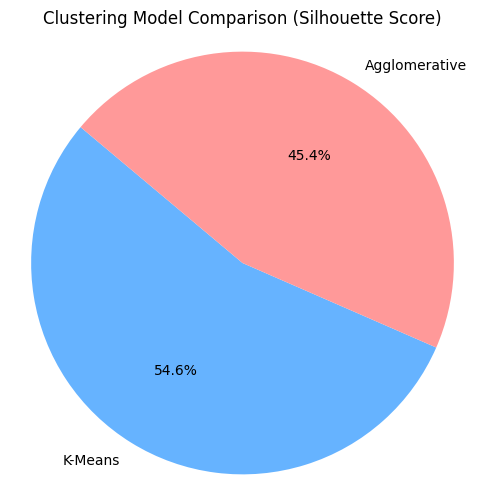

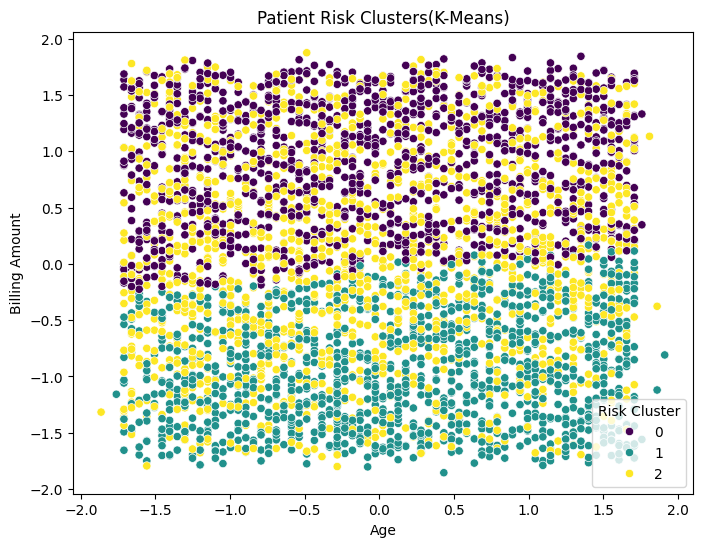

55500


In [ ]:
    
# Select and scale features
# print(len(df))
df_ssf = df.sample(n=4000,random_state=42)
cluster_data = df_ssf[['Age', 'Billing Amount', 'Length of Stay']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Cluster patients using KMeans
print("\n--- Patient Risk Clustering (K-Means) ---")
kmeans = KMeans(n_clusters=3, random_state=42)
df_ssf['Risk Cluster'] = kmeans.fit_predict(scaled_data)
kmeans_sil = silhouette_score(scaled_data, df_ssf['Risk Cluster'])
db_score = davies_bouldin_score(scaled_data, df_ssf['Risk Cluster'])
print(f"Silhouette Score: {kmeans_sil:.3f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")

print("\n--- Patient Risk Clustering (AgglomerativeClustering) ---")
agg = AgglomerativeClustering(n_clusters=3)
agg_labels = agg.fit_predict(scaled_data)
df_ssf['Agglo Cluster'] = agg_labels
agg_sil = silhouette_score(scaled_data, agg_labels)
agg_db = davies_bouldin_score(scaled_data, agg_labels)
print(f"Silhouette Score: {agg_sil:.3f}")
print(f"Davies-Bouldin Index: {agg_db:.3f}")

#Plotting the silhouette scores in pie chart
labels = ['K-Means', 'Agglomerative']
silhouette_scores = [kmeans_sil, agg_sil]
colors = ['#66b3ff', '#ff9999']
plt.figure(figsize=(6,6))
plt.pie(silhouette_scores, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Clustering Model Comparison (Silhouette Score)')
plt.axis('equal')
plt.show()

# Visualize KMeans clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_ssf, x='Age', y='Billing Amount', hue='Risk Cluster', palette='viridis')
plt.title('Patient Risk Clusters(K-Means)')
plt.show()



--- Hospital Resource Forecasting (ARIMA) ---
4000


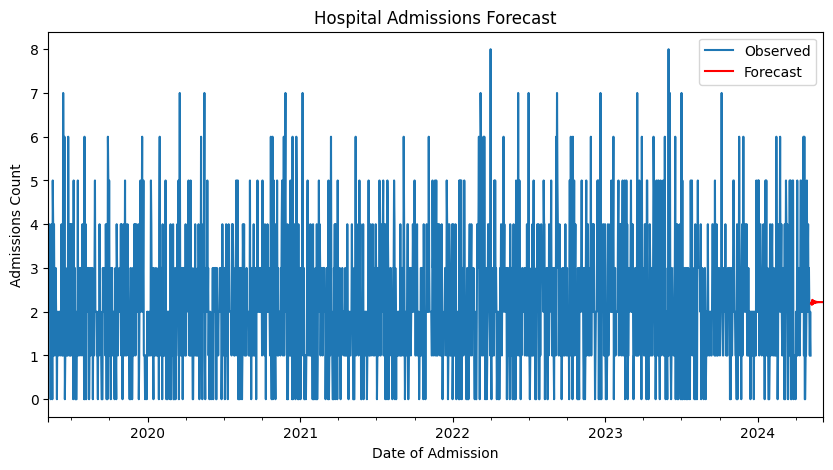

In [ ]:

print("\n--- Hospital Resource Forecasting (ARIMA) ---")
admissions = df.groupby('Date of Admission').size().asfreq('D').fillna(0)
model = ARIMA(admissions, order=(3, 1, 2))
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)

plt.figure(figsize=(10, 5))
admissions.plot(label='Observed')
forecast.plot(label='Forecast', color='red')
plt.legend()
plt.title('Hospital Admissions Forecast')
plt.ylabel('Admissions Count')
plt.show()

In [8]:

predicted = model_fit.predict(start=len(admissions)-30, end=len(admissions)-1, dynamic=False)
true = admissions[-30:]
print("MAE:", mean_absolute_error(true, predicted))
print("RMSE:", np.sqrt(mean_squared_error(true, predicted)))


MAE: 1.2212235681370578
RMSE: 1.6356322388397435
